In [ ]:
# Install necessary libraries
!pip install transformers peft datasets nltk tqdm pillow matplotlib

In [ ]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import AdamW
from PIL import Image
import os
import nltk
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# 1. Set up the environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# # Load captions
# captions_file = "/content/drive/MyDrive/Colab Notebooks/LLM Projects/Flickr 8k/captions.txt"
# image_dir = "/content/drive/MyDrive/Colab Notebooks/LLM Projects/Flickr 8k/Images"
captions_file = "/content/drive/MyDrive/trained_model/captions.txt"
image_dir = "/content/drive/MyDrive/Images"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuration for PEFT
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "self.query",
        "self.key",
        "self.value",
        "output.dense",
        "self_attn.qkv",
        "self_attn.projection",
        "mlp.fc1",
        "mlp.fc2",
    ],
)

In [ ]:
# Load model and processor
model_id = "Salesforce/blip-image-captioning-base"
model = AutoModelForVision2Seq.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Apply PEFT to the model
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,455,872 || all params: 252,869,948 || trainable%: 2.1576


In [ ]:
captions_dict = {}
with open(captions_file, 'r') as f:
  lines = f.readlines()
  for line in lines[1:10000]:
        parts = line.strip().split(',', 1)
        if len(parts) == 2:
            image_file, caption = parts
            if image_file not in captions_dict:
                captions_dict[image_file] = caption
            # captions_dict[image_file].append(caption)

In [ ]:
len(captions_dict)

2000

In [ ]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, image_dir, captions_dict, processor):
        self.image_dir = image_dir
        self.captions_dict = captions_dict
        self.image_files = list(captions_dict.keys())
        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert('RGB')
        caption = self.captions_dict[image_file]
        # caption = captions[0]  # Using the first caption for simplicity

        encoding = self.processor(images=image, padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = caption
        return encoding

def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [ ]:
# Load the custom dataset
# img_folder = "/content/drive/MyDrive/Colab Notebooks/LLM Projects/Flickr 8k/Images"
# captions_file = "/content/drive/MyDrive/Colab Notebooks/LLM Projects/Flickr 8k/captions.txt"
# full_dataset = FlickrImageCaptioningDataset(img_folder, captions_file, processor)
# Create dataset
full_dataset = ImageCaptioningDataset(image_dir, captions_dict, processor)

In [ ]:
full_dataset[0]

{'pixel_values': tensor([[[-0.9456, -0.1280, -0.2448,  ..., -1.7339, -1.7047, -1.7193],
          [-1.0039, -0.1280, -0.2302,  ..., -1.6901, -1.6463, -1.7631],
          [-1.0477, -0.1280, -0.2010,  ..., -1.6755, -1.7193, -1.5587],
          ...,
          [ 0.7625,  0.5873,  0.6603,  ...,  0.7041,  0.6603,  0.6603],
          [ 0.9814,  1.7406,  1.9303,  ...,  0.6895,  0.6749,  0.6749],
          [ 1.0836,  1.3172,  0.9814,  ...,  0.6895,  0.6457,  0.6749]],
 
         [[-0.9117,  0.1989,  0.0939,  ..., -1.6921, -1.6470, -1.6470],
          [-0.9567,  0.1989,  0.1089,  ..., -1.6170, -1.5420, -1.6771],
          [-1.0167,  0.1689,  0.1389,  ..., -1.6170, -1.6170, -1.4069],
          ...,
          [-0.4914, -0.2813,  0.2139,  ...,  1.0243,  0.9943,  1.0243],
          [-0.5215,  1.3245,  1.7147,  ...,  1.0393,  1.0093,  1.0093],
          [-0.2813,  0.3640, -0.3114,  ...,  1.0393,  1.0093,  0.9943]],
 
         [[-0.3995,  0.3399,  0.1835,  ..., -1.4376, -1.4091, -1.4376],
          [-

In [ ]:
# Split the dataset into training and validation sets
train_size = int(0.85 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [ ]:
len(train_dataset), len(val_dataset)

(1700, 300)

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=10, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=10, collate_fn=collate_fn)

In [ ]:
# Setup optimizer
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): BlipForConditionalGeneration(
      (vision_model): BlipVisionModel(
        (embeddings): BlipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (encoder): BlipEncoder(
          (layers): ModuleList(
            (0-11): 12 x BlipEncoderLayer(
              (self_attn): BlipAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=2304, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=2304, bias=False)
                  

In [ ]:
# Training loop
model.train()
for epoch in range(20):  # Adjust the number of epochs as needed
    print(f"Epoch {epoch + 1}/{40}")
    epoch_loss = 0
    for batch in train_dataloader:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        attention_mask = batch.pop("attention_mask").to(device)

        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            labels=input_ids,
            attention_mask=attention_mask,
        )

        loss = outputs.loss
        # loss = loss  # Convert loss to torch.float32

        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss. Skipping batch.")
            continue

        epoch_loss += loss.item()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}")

# Save the fine-tuned model
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/LLM Projects/Finetuned_blip/caption')

Epoch 1/40
Average Loss for Epoch 1: 3.1780
Epoch 2/40
Average Loss for Epoch 2: 3.1951
Epoch 3/40
Average Loss for Epoch 3: 3.1818
Epoch 4/40
Average Loss for Epoch 4: 3.1548
Epoch 5/40
Average Loss for Epoch 5: 3.1153
Epoch 6/40
Average Loss for Epoch 6: 3.1172
Epoch 7/40


In [ ]:
# Load the fine-tuned model and processor
model_path = '/content/drive/MyDrive/Colab Notebooks/LLM Projects/Finetuned_blip/caption'
finetuned_model = AutoModelForVision2Seq.from_pretrained(model_path)
# processor = AutoProcessor.from_pretrained(model_id)

Generating captions with finetuned model:


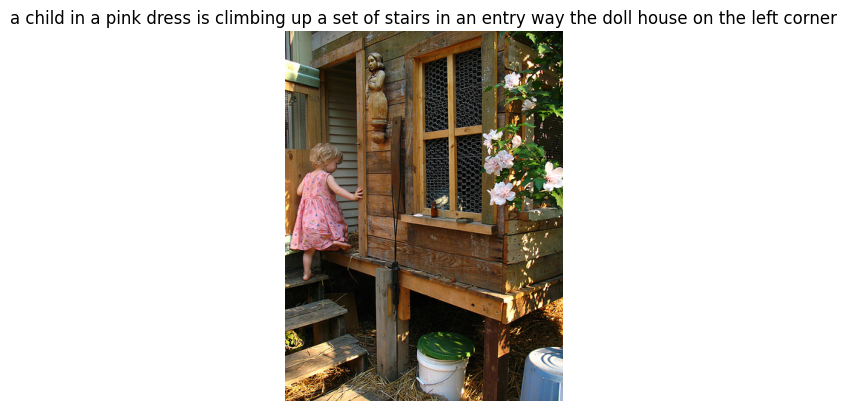

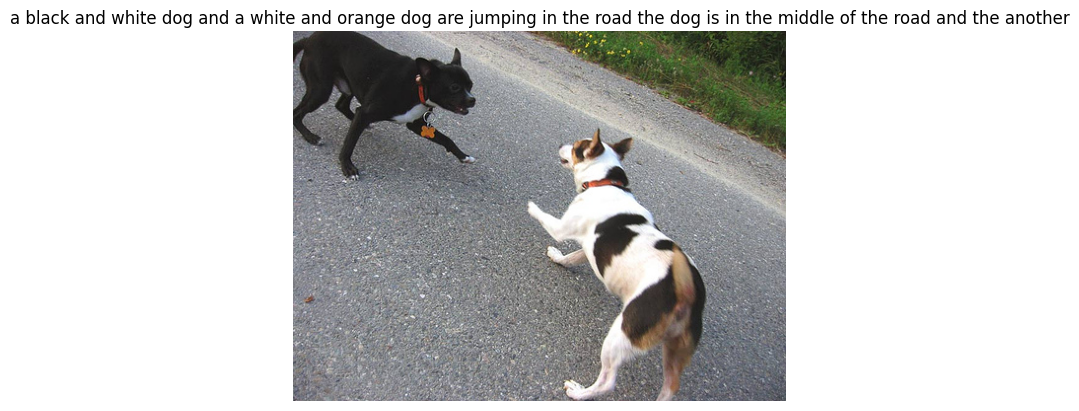

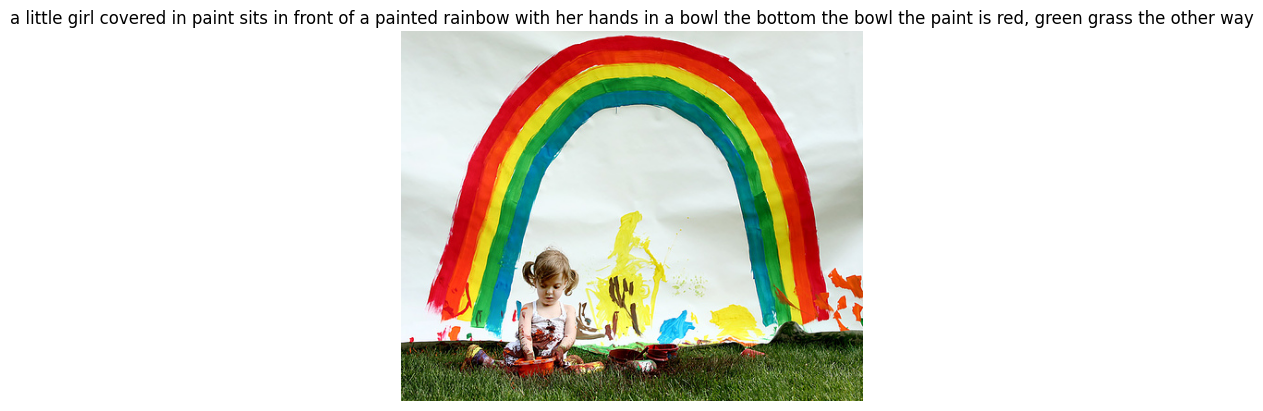

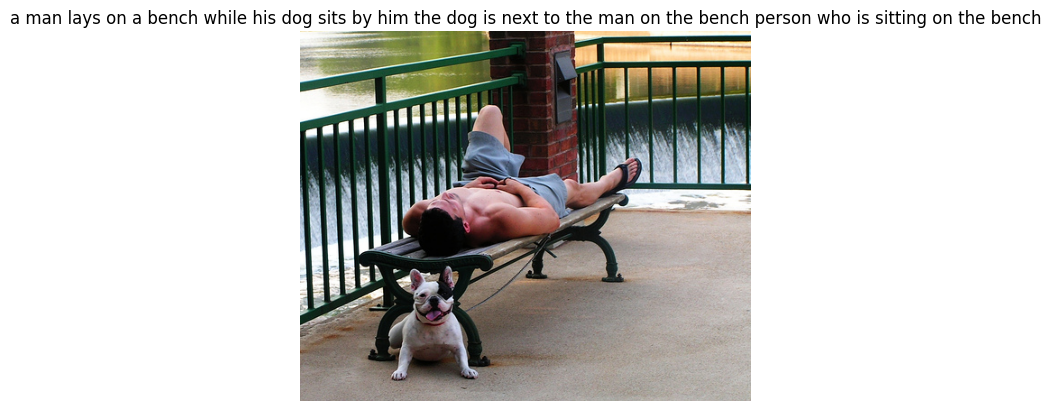

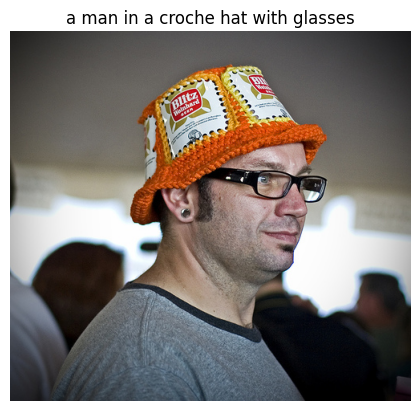

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import os

def visualize_image_with_caption(image_path, caption):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()

def generate_and_plot_captions(model, processor, image_dir, captions_dict, device, num_images=5):
    model.eval()
    images = list(captions_dict.keys())[:num_images]
    with torch.no_grad():
        for image_file in images:
            image_path = os.path.join(image_dir, image_file)
            image = Image.open(image_path).convert('RGB')
            pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
            generated_output = model.generate(pixel_values=pixel_values, max_new_tokens=64)
            generated_caption = processor.batch_decode(generated_output, skip_special_tokens=True)[0]
            visualize_image_with_caption(image_path, generated_caption)

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
finetuned_model.to(device)

# Generate and plot captions after finetuning
print("Generating captions with finetuned model:")
generate_and_plot_captions(finetuned_model, processor, image_dir, captions_dict, device)
